# Mouse Brain Multimodal Tutorial

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of AI for Health (AIH), Talavera-López Lab
- **Date of Creation:** 18.05.2023
- **Date of Last Modification:** 21.08.2024

In this tutorial we apply NicheCompass to a single multimodal sample (postnatal day 22 coronal section) of the spatial ATAC-RNA-seq mouse brain dataset from [Zhang, D. et al. Spatial epigenome–transcriptome co-profiling of mammalian tissues. Nature 1–10 (2023)](https://www.nature.com/articles/s41586-023-05795-1).

The sample has:
- 9215 observations at spot resolution with spot rna cluster and atac cluster annotations
- 22,914 probed genes
- 121,068 called peaks

- Check the repository [README.md](https://github.com/sebastianbirk/nichecompass#installation) for NicheCompass installation instructions.
- The data for this tutorial can be downloaded from [Google Drive](https://drive.google.com/drive/folders/1l9W0MDVZ451k1L7s6GGH4ONH4tEK4EKj). It has to be stored under ```<repository_root>/data/spatial_omics/```.
    - spatial_atac_rna_seq_mouse_brain_atac.h5ad
    - spatial_atac_rna_seq_mouse_brain.h5ad
    - spatial_atac_rna_seq_mouse_brain_cell_type_annotations.csv
- A pretrained model to run only the analysis can be downloaded from [Google Drive](https://drive.google.com/drive/folders/1z2DQHV9hG22B5OSWox8U3usf_8LKZGGH). It has to be stored under ```<repository_root>/artifacts/multimodal/<timestamp>/model/```.
    - ```<timestamp>```: 22082024_142839

## 1. Setup

### 1.1 Import Libraries

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import random
import warnings
from datetime import datetime

import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                add_multimodal_mask_to_adata,
                                create_new_color_dict,
                                compute_communication_gp_network,
                                visualize_communication_gp_network,
                                extract_gp_dict_from_collectri_tf_network,
                                extract_gp_dict_from_mebocost_ms_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps_v2,
                                get_gene_annotations,
                                generate_enriched_gp_info_plots,
                                generate_multimodal_mapping_dict,
                                get_unique_genes_from_gp_dict)

### 1.2 Define Parameters

In [ ]:
### Dataset ###
dataset = "spatial_atac_rna_seq_mouse_brain"
species = "mouse"
spatial_key = "spatial"
n_neighbors = 4
n_sampled_neighbors = 4
filter_genes = True
n_svg = 3000
n_svp = 15000
filter_peaks = True
min_cell_peak_thresh_ratio = 0.005 # 0.05%
min_cell_gene_thresh_ratio = 0.005 # 0.05%

### Model ###
# AnnData keys
counts_key = "counts"
adj_key = "spatial_connectivities"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
gp_targets_mask_key = "nichecompass_gp_targets"
gp_targets_categories_mask_key = "nichecompass_gp_targets_categories"
gp_sources_mask_key = "nichecompass_gp_sources"
gp_sources_categories_mask_key = "nichecompass_gp_sources_categories"
latent_key = "nichecompass_latent"

# Architecture
active_gp_thresh_ratio = 0.01
conv_layer_encoder = "gatv2conv" # change to "gcnconv" if not enough compute and memory

# Trainer
n_epochs = 400
n_epochs_all_gps = 25
lr = 0.001
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_chrom_access_recon = 300.
lambda_l1_masked = 0. # prior GP  regularization
lambda_l1_addon = 30. # de novo GP regularization
edge_batch_size = 256 # increase if more memory available or decrease to save memory
use_cuda_if_available = True

### Analysis ###
cell_type_key = "cell_type"
latent_leiden_resolution = 0.6
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
sample_key = "batch"
spot_size = 30
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

### 1.3 Run Notebook Setup

In [ ]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [ ]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths

In [ ]:
# Define paths
ga_data_folder_path = "../../../data/gene_annotations"
gp_data_folder_path = "../../../data/gene_programs"
so_data_folder_path = "../../../data/spatial_omics"
omnipath_lr_network_file_path = f"{gp_data_folder_path}/omnipath_lr_network.csv"
nichenet_lr_network_file_path = f"{gp_data_folder_path}/nichenet_lr_network_v2_{species}.csv"
nichenet_ligand_target_matrix_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix_v2_{species}.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
collectri_tf_network_file_path = f"{gp_data_folder_path}/collectri_tf_network_{species}.csv"
marker_gp_folder_path = f"{gp_data_folder_path}/marker_gps"
gene_orthologs_mapping_file_path = f"{ga_data_folder_path}/human_mouse_gene_orthologs.csv"
gtf_file_path = f"{ga_data_folder_path}/gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz"
artifacts_folder_path = f"../../../artifacts"
model_folder_path = f"{artifacts_folder_path}/multimodal/{current_timestamp}/model"
figure_folder_path = f"{artifacts_folder_path}/multimodal/{current_timestamp}/figures"

### 1.5 Create Directories

In [ ]:
os.makedirs(model_folder_path, exist_ok=True)
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(so_data_folder_path, exist_ok=True)

### 1.6 Download Files (Optional)
You can skip this part if you have downloaded the files mentioned above manually, or you are using your own data.

In [ ]:
gdown.download("https://drive.google.com/uc?id=1WH_9PYV_AEcLd5QVNILig-_gfS-EdRVR', so_data_folder_path+'/spatial_atac_rna_seq_mouse_brain_atac.h5ad")
gdown.download("https://drive.google.com/uc?id=1NpRynEDnGnxab6sHJy4AeitSKnwfX2Mi', so_data_folder_path+'/spatial_atac_rna_seq_mouse_brain.h5ad")
gdown.download("https://drive.google.com/file/d/1w3eorJojnndhmeTicbin7eRjR8Pwj7O-', so_data_folder_path+'/spatial_atac_rna_seq_mouse_brain_cell_type_annotations.csv")

## 2. Model Preparation

### 2.1 Create Prior Knowledge Gene Program (GP) Mask

- NicheCompass expects a prior GP mask as input, which it will use to make its latent feature space interpretable (through linear masked decoders). 
- The user can provide a custom GP mask to NicheCompass based on the biological question of interest.
- As a default, we create a GP mask based on four databases of prior knowledge of inter- and intracellular interaction pathways:
    - OmniPath (Ligand-Receptor GPs)
    - MEBOCOST (Enzyme-Sensor GPs)
    - CollecTRI (Transcriptional Regulation GPs)
    - NicheNet (Combined Interaction GPs)

In [ ]:
# Retrieve OmniPath GPs (source: ligand genes; target: receptor genes)
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    species=species,
    load_from_disk=False,
    save_to_disk=True,
    lr_network_file_path=omnipath_lr_network_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True,
    gp_gene_count_distributions_save_path=f"{figure_folder_path}" \
                                           "/omnipath_gp_gene_count_distributions.svg")

In [ ]:
# Display example OmniPath GP
omnipath_gp_names = list(omnipath_gp_dict.keys())
random.shuffle(omnipath_gp_names)
omnipath_gp_name = omnipath_gp_names[0]
print(f"{omnipath_gp_name}: {omnipath_gp_dict[omnipath_gp_name]}")

In [ ]:
# Retrieve NicheNet GPs (source: ligand genes; target: receptor genes, target genes)
nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
    species=species,
    version="v2",
    keep_target_genes_ratio=1.,
    max_n_target_genes_per_gp=250,
    load_from_disk=False,
    save_to_disk=True,
    lr_network_file_path=nichenet_lr_network_file_path,
    ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True)

In [ ]:
# Display example NicheNet GP
nichenet_gp_names = list(nichenet_gp_dict.keys())
random.shuffle(nichenet_gp_names)
nichenet_gp_name = nichenet_gp_names[0]
print(f"{nichenet_gp_name}: {nichenet_gp_dict[nichenet_gp_name]}")

In [ ]:
# Retrieve MEBOCOST GPs (source: enzyme genes; target: sensor genes)
mebocost_gp_dict = extract_gp_dict_from_mebocost_ms_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species=species,
    plot_gp_gene_count_distributions=True)

In [ ]:
# Display example MEBOCOST GP
mebocost_gp_names = list(mebocost_gp_dict.keys())
random.shuffle(mebocost_gp_names)
mebocost_gp_name = mebocost_gp_names[0]
print(f"{mebocost_gp_name}: {mebocost_gp_dict[mebocost_gp_name]}")

In [ ]:
# Retrieve CollecTRI GPs (source: -; target: transcription factor genes, target genes)
collectri_gp_dict = extract_gp_dict_from_collectri_tf_network(
        species=species,
        tf_network_file_path=collectri_tf_network_file_path,
        load_from_disk=False,
        save_to_disk=True,
        plot_gp_gene_count_distributions=True)

In [ ]:
# Display example CollecTRI GP
collectri_gp_names = list(collectri_gp_dict.keys())
random.shuffle(collectri_gp_names)
collectri_gp_name = collectri_gp_names[0]
print(f"{collectri_gp_name}: {collectri_gp_dict[collectri_gp_name]}")

In [ ]:
# Filter and combine GPs
gp_dicts = [omnipath_gp_dict, nichenet_gp_dict, mebocost_gp_dict, collectri_gp_dict]
combined_gp_dict = filter_and_combine_gp_dict_gps_v2(
    gp_dicts,
    verbose=True)

print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_gp_dict)}.")

### 2.2 Load Data & Compute Spatial Neighbor Graph

- NicheCompass expects a precomputed spatial adjacency matrix stored in 'adata.obsp[adj_key]'.
- The user can customize the spatial neighbor graph construction based on the biological question of interest.
- In the multimodal setting, we will provide one adata object per modality to NicheCompass.

In [ ]:
# Read data
adata = sc.read_h5ad(
        f"{so_data_folder_path}/{dataset}.h5ad")
adata_atac = sc.read_h5ad(
        f"{so_data_folder_path}/{dataset}_atac.h5ad")

In [ ]:
# Load and add cell type annotations
cell_type_df = pd.read_csv(f"{so_data_folder_path}/{dataset}_cell_type_annotations.csv", index_col=0)
cell_type_df.rename({"predicted.celltype": cell_type_key}, axis=1, inplace=True)
cell_type_df.drop("ATAC_clusters", axis=1, inplace=True)
adata.obs = adata.obs.merge(cell_type_df, left_index=True, right_index=True, how="left")

In [ ]:
# Compute spatial neighborhood
sq.gr.spatial_neighbors(adata,
                        coord_type="generic",
                        spatial_key=spatial_key,
                        n_neighs=n_neighbors)

# Make adjacency matrix symmetric
adata.obsp[adj_key] = (
    adata.obsp[adj_key].maximum(
        adata.obsp[adj_key].T))

### 2.3 Filter Genes & Peaks

In [ ]:
if filter_genes:
    print("Filtering genes...")
    # Filter genes and only keep ligand, receptor, enzyme, sensor, and
    # the 'n_svg' spatially variable genes
    gp_dict_genes = get_unique_genes_from_gp_dict(
        gp_dict=combined_gp_dict,
            retrieved_gene_entities=["sources", "targets"])
    print(f"Starting with {len(adata.var_names)} genes.")
    min_cells = int(adata.shape[0] * min_cell_gene_thresh_ratio)
    sc.pp.filter_genes(adata, min_cells=min_cells)
    print(f"Keeping {len(adata.var_names)} genes after filtering genes with "
          f"counts in less than {int(adata.shape[0] * min_cell_gene_thresh_ratio)} cells.")
    
    # Identify spatially variable genes
    sq.gr.spatial_autocorr(adata, mode="moran", genes=adata.var_names)
    svg_genes = adata.uns["moranI"].index[:n_svg].tolist()
    adata.var["spatially_variable"] = adata.var_names.isin(svg_genes)
    adata = adata[:, adata.var["spatially_variable"] == True]
    print(f"Keeping {len(adata.var_names)} spatially variable genes.")
    
if filter_peaks:
    print("\nFiltering peaks...")
    print(f"Starting with {len(adata_atac.var_names)} peaks.")
    # Filter out peaks that are rarely detected to reduce GPU footprint of model
    min_cells = int(adata_atac.shape[0] * min_cell_peak_thresh_ratio)
    sc.pp.filter_genes(adata_atac, min_cells=min_cells)
    print(f"Keeping {len(adata_atac.var_names)} peaks after filtering peaks with "
          f"counts in less than {int(adata_atac.shape[0] * min_cell_peak_thresh_ratio)} cells.")
    
    # Filter spatially variable peaks
    adata_atac.obsp["spatial_connectivities"] = adata.obsp["spatial_connectivities"]
    adata_atac.obsp["spatial_distances"] = adata.obsp["spatial_distances"]

    sq.gr.spatial_autocorr(adata_atac,
                           mode="moran",
                           genes=adata_atac.var_names)
    sv_peaks = adata_atac.uns["moranI"].index[:n_svp].tolist()
    adata_atac.var["spatially_variable"] = adata_atac.var_names.isin(sv_peaks)
    adata_atac = adata_atac[:, adata_atac.var["spatially_variable"] == True]
    print(f"Keeping {len(adata_atac.var_names)} peaks after filtering spatially variable "
          f"peaks.")

### 2.4 Annotate Genes & Peaks

Next we will add positional annotations to genes and peaks to be able to match spatially proximal peaks to genes.

In [ ]:
adata, adata_atac = get_gene_annotations(
    adata=adata,
    adata_atac=adata_atac,
    gtf_file_path=gtf_file_path)

In [ ]:
# Display gene annotations
adata.var[["chrom", "chromStart", "chromEnd"]]

In [ ]:
# Display peak annotations
adata_atac.var[["chrom", "chromStart", "chromEnd"]]

### 2.5 Add GP Mask to Data

In [ ]:
# Add the GP dictionary as binary masks to the adata
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_gp_dict,
    adata=adata,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_targets_categories_mask_key=gp_targets_categories_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_sources_categories_mask_key=gp_sources_categories_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=2,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=1,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None,
    plot_gp_gene_count_distributions=True)

### 2.6 Add Chromatin Accessibility Mask to Data

Based on spatial proximity to the genes in the GP mask, we will add a chromatin accessibility mask.

In [ ]:
gene_peak_mapping_dict = generate_multimodal_mapping_dict(
    adata=adata,
    adata_atac=adata_atac)

In [ ]:
adata, adata_atac = add_multimodal_mask_to_adata(
    adata=adata,
    adata_atac=adata_atac,
    gene_peak_mapping_dict=gene_peak_mapping_dict)

print(f"Keeping {len(adata_atac.var_names)} peaks after filtering peaks with "
      "no matching genes in gp mask.")

### 2.7 Explore Data

In [ ]:
cell_type_colors = create_new_color_dict(
    adata=adata,
    skip_default_colors=50,
    cat_key=cell_type_key)

In [ ]:
print(f"Number of nodes (observations): {adata.layers['counts'].shape[0]}")
print(f"Number of gene node features: {adata.layers['counts'].shape[1]}")
print(f"Number of peak node features: {adata_atac.layers['counts'].shape[1]}")

# Visualize spot-level annotated data in physical space
sc.pl.spatial(adata,
              color=cell_type_key,
              palette=cell_type_colors,
              spot_size=spot_size)

## 3. Model Training

### 3.1 Initialize, Train & Save Model

In [ ]:
# Initialize model
model = NicheCompass(adata,
                     adata_atac,
                     counts_key=counts_key,
                     adj_key=adj_key,
                     gp_names_key=gp_names_key,
                     active_gp_names_key=active_gp_names_key,
                     gp_targets_mask_key=gp_targets_mask_key,
                     gp_targets_categories_mask_key=gp_targets_categories_mask_key,
                     gp_sources_mask_key=gp_sources_mask_key,
                     gp_sources_categories_mask_key=gp_sources_categories_mask_key,
                     latent_key=latent_key,
                     conv_layer_encoder=conv_layer_encoder,
                     active_gp_thresh_ratio=active_gp_thresh_ratio)

In [ ]:
# Train model
model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_chrom_access_recon=lambda_chrom_access_recon,
            lambda_l1_masked=lambda_l1_masked,
            lambda_l1_addon=lambda_l1_addon,
            edge_batch_size=edge_batch_size,
            use_cuda_if_available=use_cuda_if_available,
            n_sampled_neighbors=n_sampled_neighbors,
            verbose=True)

In [ ]:
# Compute latent neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)

# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

In [ ]:
# Save trained model
model.save(dir_path=model_folder_path,
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad",
           save_adata_atac=True,
           adata_atac_file_name=f"adata_atac.h5ad"
          )

## 4. Analysis

In [103]:
load_timestamp = "22082024_142839"
# load_timestamp = current_timestamp # uncomment if you trained the model in this notebook

figure_folder_path = f"{artifacts_folder_path}/multimodal/{load_timestamp}/figures"
model_folder_path = f"{artifacts_folder_path}/multimodal/{load_timestamp}/model"

os.makedirs(figure_folder_path, exist_ok=True)

In [104]:
# Load trained model
model = NicheCompass.load(dir_path=model_folder_path,
                          adata=None,
                          adata_file_name="adata.h5ad",
                          adata_atac=None,
                          adata_atac_file_name="adata_atac.h5ad",
                          gp_names_key=gp_names_key)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb, include_chrom_access_recon_loss: True, atac_recon_loss: nb 
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ONE HOP GCN NORM ATAC NODE LABEL AGGREGATOR
ENCODER -> n_input: 6069, n_cat_covariates_embed_input: 0, n_hidden: 1996, n_latent: 1896, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gatv2conv, n_attention_heads: 4, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 1896, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 2773
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 1896, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 2773
MASKED TARGET ATAC DECODER -> n_prior_gp_input: 1896, n_addon_gp_input: 100, n_cat

In [105]:
samples = model.adata.obs[sample_key].unique().tolist()

### 4.1 Visualize NicheCompass Latent GP Space

Let's look at the preservation of cell type annotations in the latent GP space. Note that the goal of NicheCompass is not a separation of cell types but rather to identify spatially consistent cell niches.

In [106]:
cell_type_colors = create_new_color_dict(
    adata=model.adata,
    skip_default_colors=50,
    cat_key=cell_type_key)

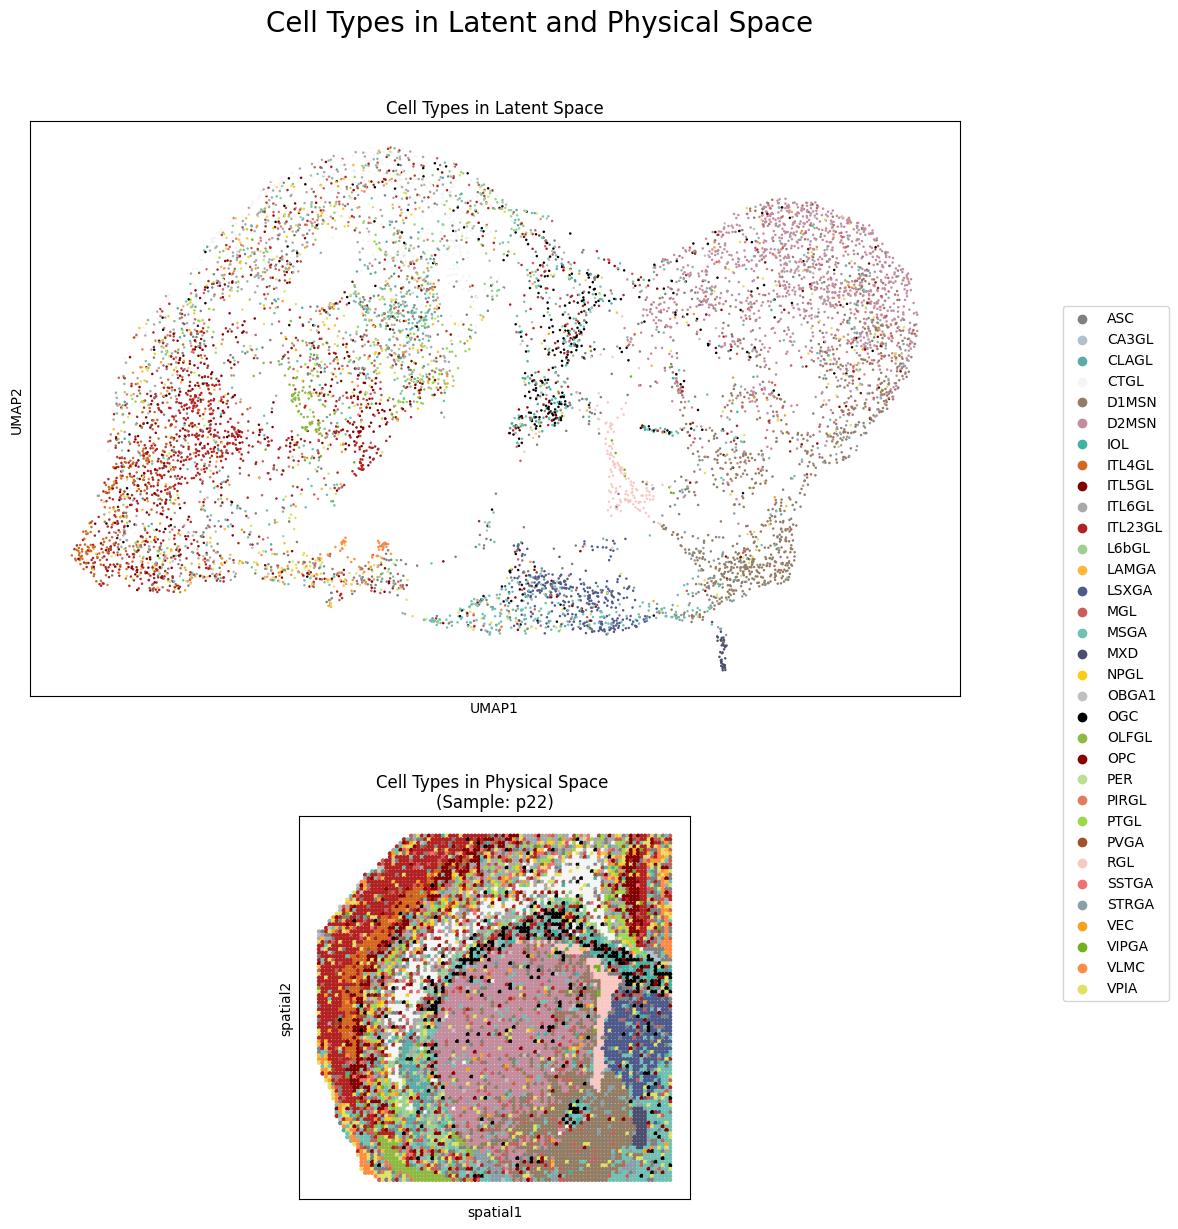

In [107]:
# Create plot of cell type annotations in physical and latent space
groups = None
save_fig = True
file_path = f"{figure_folder_path}/" \
            "cell_types_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t="Cell Types in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[cell_type_key],
           groups=groups,palette=cell_type_colors,
           title=f"Cell Types in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[cell_type_key],
                  groups=groups,
                  palette=cell_type_colors,
                  spot_size=spot_size,
                  title=f"Cell Types in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

### 4.2 Identify Niches

We compute Leiden clustering of the NicheCompass latent GP space to identify spatially consistent cell niches.

In [127]:
latent_leiden_resolution = 0.5

In [128]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)

In [129]:
latent_cluster_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=latent_cluster_key)

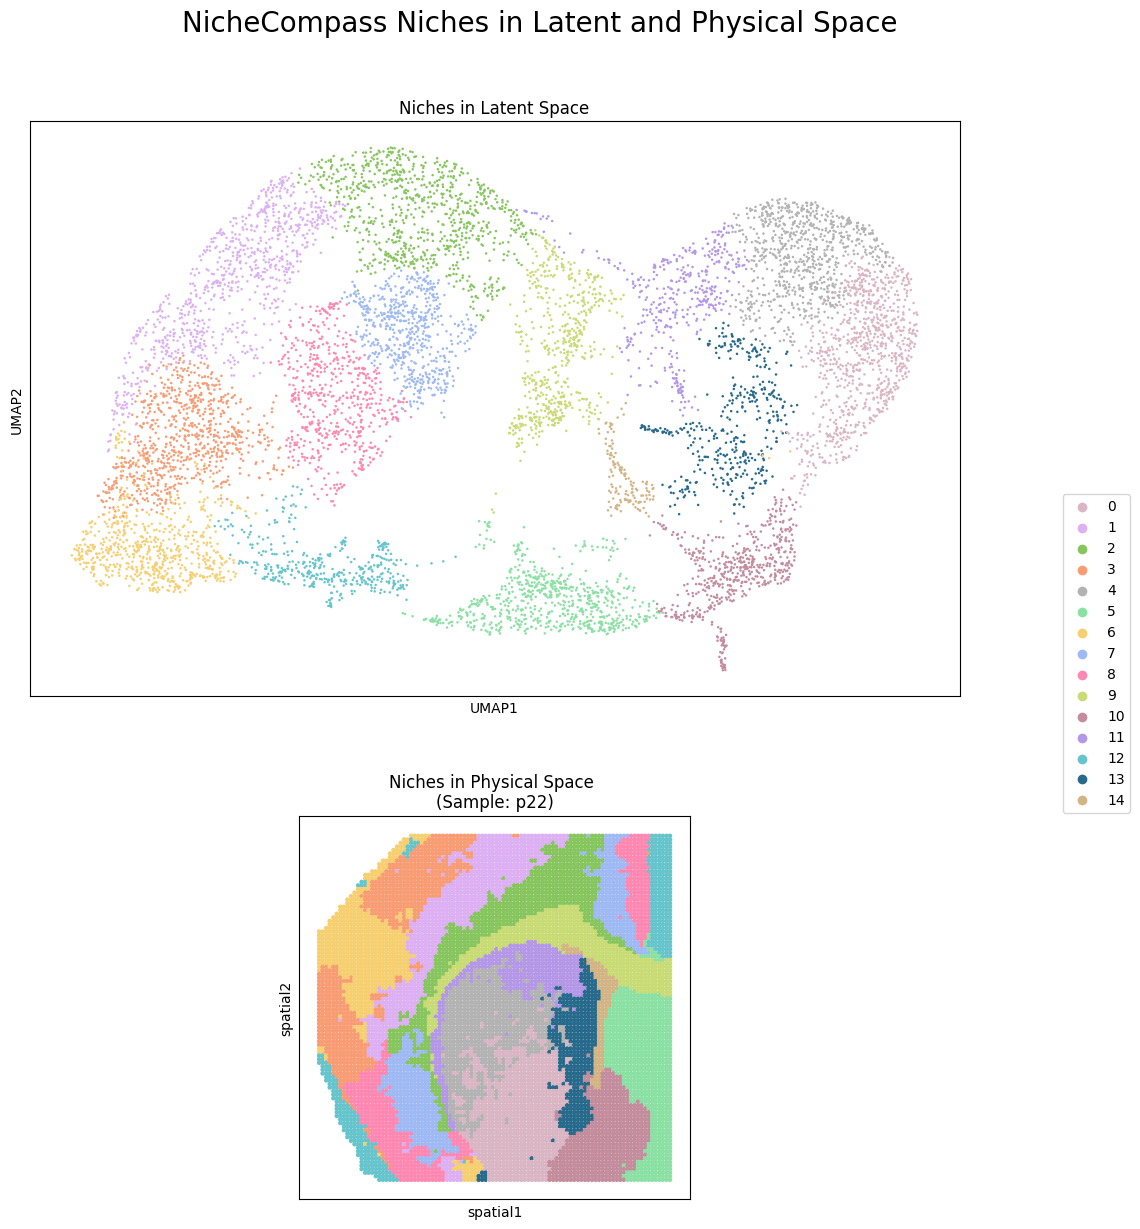

In [130]:
# Create plot of latent cluster / niche annotations in physical and latent space
groups = None # set this to a specific cluster for easy visualization, e.g. ["0"]
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            "niches_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"NicheCompass Niches " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[latent_cluster_key],
           groups=groups,
           palette=latent_cluster_colors,
           title=f"Niches in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[latent_cluster_key],
                  groups=groups,
                  palette=latent_cluster_colors,
                  spot_size=spot_size,
                  title=f"Niches in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

### 4.3 Characterize Niches

Now we will characterize the identified cell niches.

#### 4.3.1 Niche Composition

We can analyze the niche composition in terms of cell type labels.

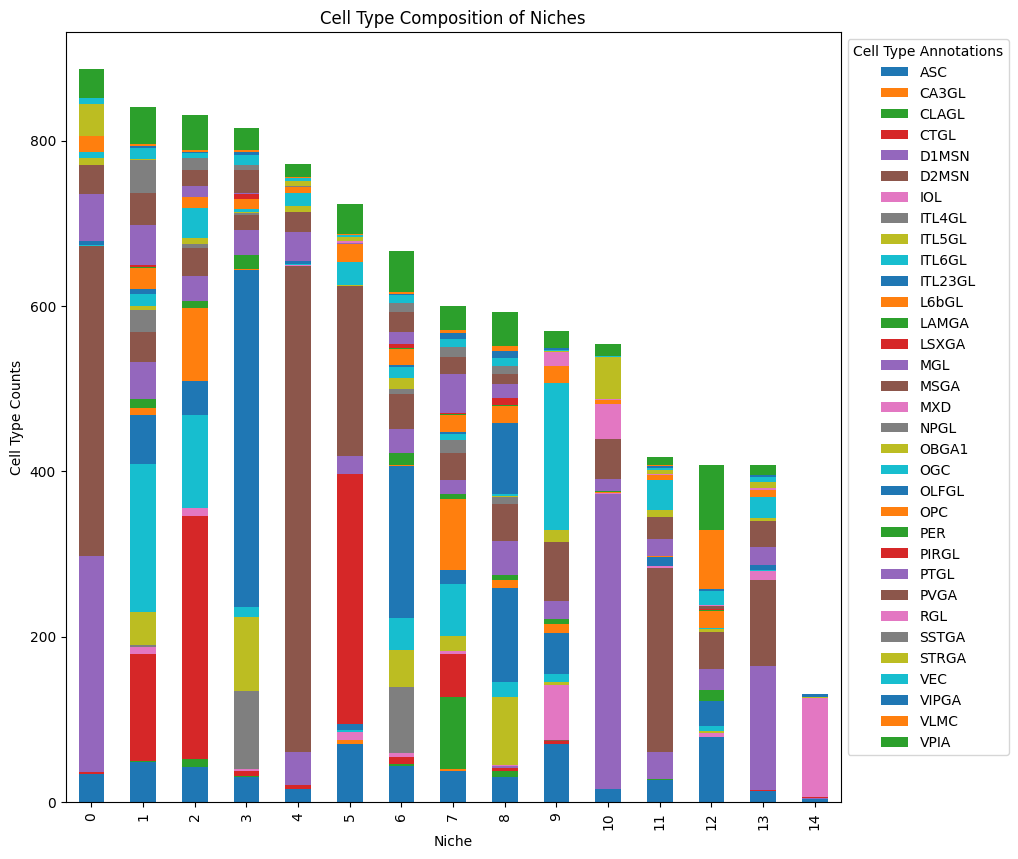

In [139]:
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            f"niche_composition.svg"

df_counts = (model.adata.obs.groupby([latent_cluster_key, cell_type_key])
             .size().unstack())
df_counts.plot(kind="bar", stacked=True, figsize=(10,10))
legend = plt.legend(bbox_to_anchor=(1, 1), loc="upper left", prop={'size': 10})
legend.set_title("Cell Type Annotations", prop={'size': 10})
plt.title("Cell Type Composition of Niches")
plt.xlabel("Niche")
plt.ylabel("Cell Type Counts")
if save_fig:
    plt.savefig(file_path,
                bbox_extra_artists=(legend,),
                bbox_inches="tight")

#### 4.3.2 Differential GPs

Now we can test which GPs are differentially expressed in a niche. To this end, we will perform differential GP testing of a selected niche, e.g. niche "9" (```selected_cats = ["9"]```) vs all other niches (```comparison_cats = "rest"```). However, differential GP testing can also be performed in the following ways:
- Set ```selected_cats = None``` to perform differential GP testing across all niches, as opposed to just for one specific niche.
- Set ```comparison_cats = ["12"]``` to perform differential GP testing against niche "12" as opposed to against all other niches.

We choose an absolute log bayes factor threshold of 2.3 to determine strongly enriched GPs (see https://en.wikipedia.org/wiki/Bayes_factor).

In [140]:
# Check number of active GPs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

Number of total gene programs: 1996.
Number of active gene programs: 1370.


In [141]:
# Display example active GPs
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True].head()

,gp_name,all_gp_idx,gp_active,active_gp_idx,n_source_genes,n_non_zero_source_genes,n_target_genes,n_non_zero_target_genes,gp_source_genes,gp_target_genes,gp_source_genes_weights,gp_target_genes_weights,gp_source_genes_importances,gp_target_genes_importances,n_source_peaks,n_non_zero_source_peaks,n_target_peaks,n_non_zero_target_peaks,gp_source_peaks,gp_target_peaks,gp_source_peaks_weights,gp_target_peaks_weights,gp_source_peaks_importances,gp_target_peaks_importances
0,AFDN_ligand_receptor_GP,0,True,0,0,0,3,3,[],"[Ephb6, Nrxn2, Nrxn3]",[],"[-0.0488, -0.031, 0.0287]",[],"[0.4498, 0.2857, 0.2645]",0,0,19,19,[],"[chr19:6531886-6532666, chr12:88860016-8886078...",[],"[-0.0596, 0.0327, 0.0312, -0.0312, -0.0259, 0....",[],"[0.175, 0.096, 0.0918, 0.0917, 0.0762, 0.0564,..."
1,ARF6_ligand_receptor_GP,1,True,1,0,0,2,2,[],"[Mapk3, Pip5k1c]",[],"[-0.0274, -0.0189]",[],"[0.5924, 0.4076]",0,0,3,3,[],"[chr10:81302513-81303358, chr10:81292503-81293...",[],"[0.0195, -0.0133, 0.0111]",[],"[0.4439, 0.3027, 0.2534]"
3,COMPLEX:EGFR_ERBB3_ligand_receptor_GP,3,True,2,1,1,1,1,[Egfr],[Pik3r1],[-1.3019],[-0.0179],[0.9864],[0.0136],1,1,1,1,[chr11:16765987-16766842],[chr13:101767826-101768728],[-1.414],[0.0036],[0.9975],[0.0025]
4,EPHA3_ligand_receptor_GP,4,True,3,1,1,1,1,[Epha3],[Fyn],[0.117],[0.0067],[0.9458],[0.0542],0,0,2,2,[],"[chr10:39426843-39427769, chr10:39369321-39370...",[],"[-0.0347, 0.0011]",[],"[0.9688, 0.0312]"
5,EPOR_ligand_receptor_GP,5,True,4,0,0,2,2,[],"[Trpc3, Pik3r1]",[],"[-1.4366, 0.0145]",[],"[0.99, 0.01]",0,0,1,1,[],[chr13:101767826-101768728],[],[0.0024],[],[1.0]


In [144]:
# Set parameters for differential gp testing
selected_cats = ["9"]
comparison_cats = "rest"
title = f"NicheCompass Strongly Enriched Niche GPs"
log_bayes_factor_thresh = 2.3
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}" \
             "_niches_enriched_gps_heatmap.svg"

In [145]:
# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key=latent_cluster_key,
    selected_cats=selected_cats,
    comparison_cats=comparison_cats,
    log_bayes_factor_thresh=log_bayes_factor_thresh)

In [146]:
# Results are stored in a df in the adata object
model.adata.uns[differential_gp_test_results_key]

,category,gene_program,p_h0,p_h1,log_bayes_factor
0,9,Vsir_ligand_receptor_target_gene_GP,0.997842,0.002158,6.136207
1,9,Sox10_TF_target_genes_GP,0.997678,0.002322,6.062856
2,9,Add-on_71_GP,0.997604,0.002396,6.031708
3,9,Nkx3-1_TF_target_genes_GP,0.996500,0.003500,5.651483
4,9,Cldn11_ligand_receptor_target_gene_GP,0.003962,0.996038,-5.527079
...,...,...,...,...,...
239,9,Syt1_ligand_receptor_target_gene_GP,0.910552,0.089448,2.320388
240,9,Pparg_TF_target_genes_GP,0.910302,0.089698,2.317325
241,9,IL25_combined_GP,0.090433,0.909567,-2.308361
242,9,AMBN_combined_GP,0.908959,0.091041,2.300987


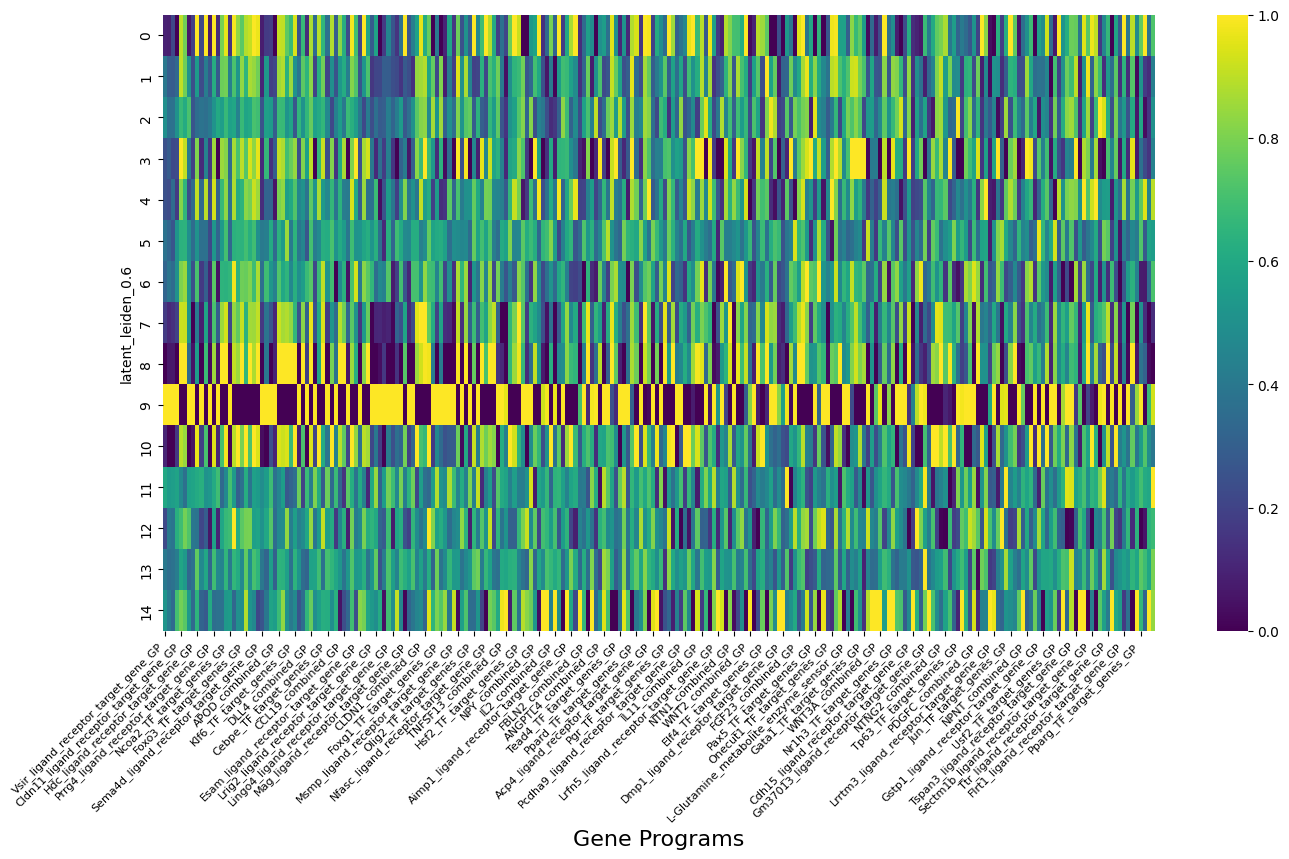

In [147]:
# Visualize GP activities of enriched GPs across niches
df = model.adata.obs[[latent_cluster_key] + enriched_gps].groupby(latent_cluster_key).mean()

scaler = MinMaxScaler()
normalized_columns = scaler.fit_transform(df)
normalized_df = pd.DataFrame(normalized_columns, columns=df.columns)
normalized_df.index = df.index

plt.figure(figsize=(16, 8))  # Set the figure size
ax = sns.heatmap(normalized_df,
            cmap='viridis',
            annot=False,
            linewidths=0)
plt.xticks(rotation=45,
           fontsize=8,
           ha="right"
          )
plt.xlabel("Gene Programs", fontsize=16)
plt.savefig(f"{figure_folder_path}/enriched_gps_heatmap.svg",
            bbox_inches="tight")

In [148]:
# Store gene program summary of enriched gene programs
save_file = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}_" \
            "niche_enriched_gps_summary.csv"

gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances",
                   "n_source_peaks",
                   "n_target_peaks",
                   "gp_source_peaks",
                   "gp_target_peaks",
                   "gp_source_peaks_importances",
                   "gp_target_peaks_importances"]

enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

Now we will have a look at the GP activities and the log normalized counts of
the most important omics features of the differential GPs.

In [ ]:
plot_label = f"log_bayes_factor_{log_bayes_factor_thresh}_cluster_{selected_cats[0]}_vs_rest"
save_figs = True

generate_enriched_gp_info_plots(
    plot_label=plot_label,
    model=model,
    sample_key=sample_key,
    differential_gp_test_results_key=differential_gp_test_results_key,
    cat_key=latent_cluster_key,
    cat_palette=latent_cluster_colors,
    n_top_enriched_gp_start_idx=0,
    n_top_enriched_gp_end_idx=10,
    feature_spaces=samples, # ["latent"]
    n_top_genes_per_gp=3,
    n_top_peaks_per_gp=3,
    save_figs=save_figs,
    figure_folder_path=f"{figure_folder_path}/",
    spot_size=spot_size)

#### 4.3.3 Cell-cell Communication

Now we will use the inferred activity of an enriched combined interaction GP to analyze the involved intercellular interactions.

In [150]:
gp_name = "Cldn11_ligand_receptor_target_gene_GP"

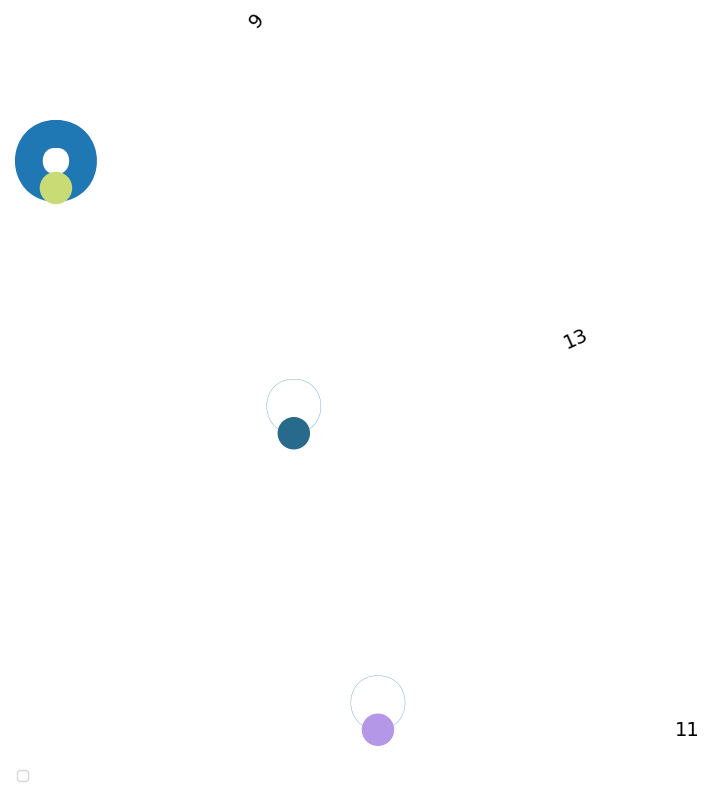

In [154]:
network_df = compute_communication_gp_network(
    gp_list=[gp_name],
    model=model,
    group_key=latent_cluster_key,
    n_neighbors=n_neighbors)

visualize_communication_gp_network(
    adata=model.adata,
    network_df=network_df,
    figsize=(9, 8),
    cat_colors=latent_cluster_colors,
    edge_type_colors=["#1f77b4"], 
    cat_key=latent_cluster_key,
    save=True,
    save_path=f"{figure_folder_path}/gp_network_{gp_name}.svg",
    )